# Stock price prediction using LSTM neural network and Tensorflow
What do we need here:
1. Load data
2. Scale data for machine learning model
3. Setup neural network
4. Compile model
5. Teach neural netowk and fit this
6. Use the model for prediction
7. Draw the results chart

In [1]:
# Requirements
!pip install yahoo_fin

In [2]:
import numpy as np
import time as tm
import datetime as dt
import tensorflow as tf

# Data preparation
from yahoo_fin import stock_info as yf
from sklearn.preprocessing import MinMaxScaler
from collections import deque

# AI
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# Graphics library
import matplotlib.pyplot as plt

2024-04-02 08:56:56.075012: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-02 08:56:56.121810: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-02 08:56:56.121851: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-02 08:56:56.121885: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-02 08:56:56.130572: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-02 08:56:56.131680: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [3]:
# SETTINGS

# Window size or the sequence length, 7 (1 week)
N_STEPS = 7

# Lookup steps, 1 is the next day, 3 = after tomorrow
LOOKUP_STEPS = [1, 2, 3]

# Stock ticker, GOOGL
STOCK = 'GOOGL'

# Current date
date_now = tm.strftime('%Y-%m-%d')
date_3_years_back = (dt.date.today() - dt.timedelta(days=1104)).strftime('%Y-%m-%d')

In [4]:
# LOAD DATA 
# from yahoo_fin 
# for 1104 bars with interval = 1d (one day)
init_df = yf.get_data(
    STOCK, 
    start_date=date_3_years_back, 
    end_date=date_now, 
    interval='1d')

In [5]:
init_df

,open,high,low,close,adjclose,volume,ticker
2021-03-25,101.452499,102.281998,99.804497,101.623001,101.623001,35616000,GOOGL
2021-03-26,101.589500,101.969498,100.192497,101.236504,101.236504,27978000,GOOGL
2021-03-29,101.108002,102.460503,100.272499,102.289497,102.289497,26492000,GOOGL
2021-03-30,102.649002,103.133499,101.807503,102.323502,102.323502,27312000,GOOGL
2021-03-31,102.720001,104.313004,102.349998,103.125999,103.125999,42570000,GOOGL
...,...,...,...,...,...,...,...
2024-03-25,149.940002,150.380005,147.820007,150.070007,150.070007,19229300,GOOGL
2024-03-26,150.220001,152.259995,149.979996,150.669998,150.669998,22149100,GOOGL
2024-03-27,151.179993,151.639999,148.899994,150.869995,150.869995,22879200,GOOGL
2024-03-28,150.850006,151.429993,150.169998,150.929993,150.929993,24485400,GOOGL


In [6]:
# remove columns which our neural network will not use
init_df = init_df.drop(['open', 'high', 'low', 'adjclose', 'ticker', 'volume'], axis=1)
# create the column 'date' based on index column
init_df['date'] = init_df.index

In [7]:
init_df

,close,date
2021-03-25,101.623001,2021-03-25
2021-03-26,101.236504,2021-03-26
2021-03-29,102.289497,2021-03-29
2021-03-30,102.323502,2021-03-30
2021-03-31,103.125999,2021-03-31
...,...,...
2024-03-25,150.070007,2024-03-25
2024-03-26,150.669998,2024-03-26
2024-03-27,150.869995,2024-03-27
2024-03-28,150.929993,2024-03-28


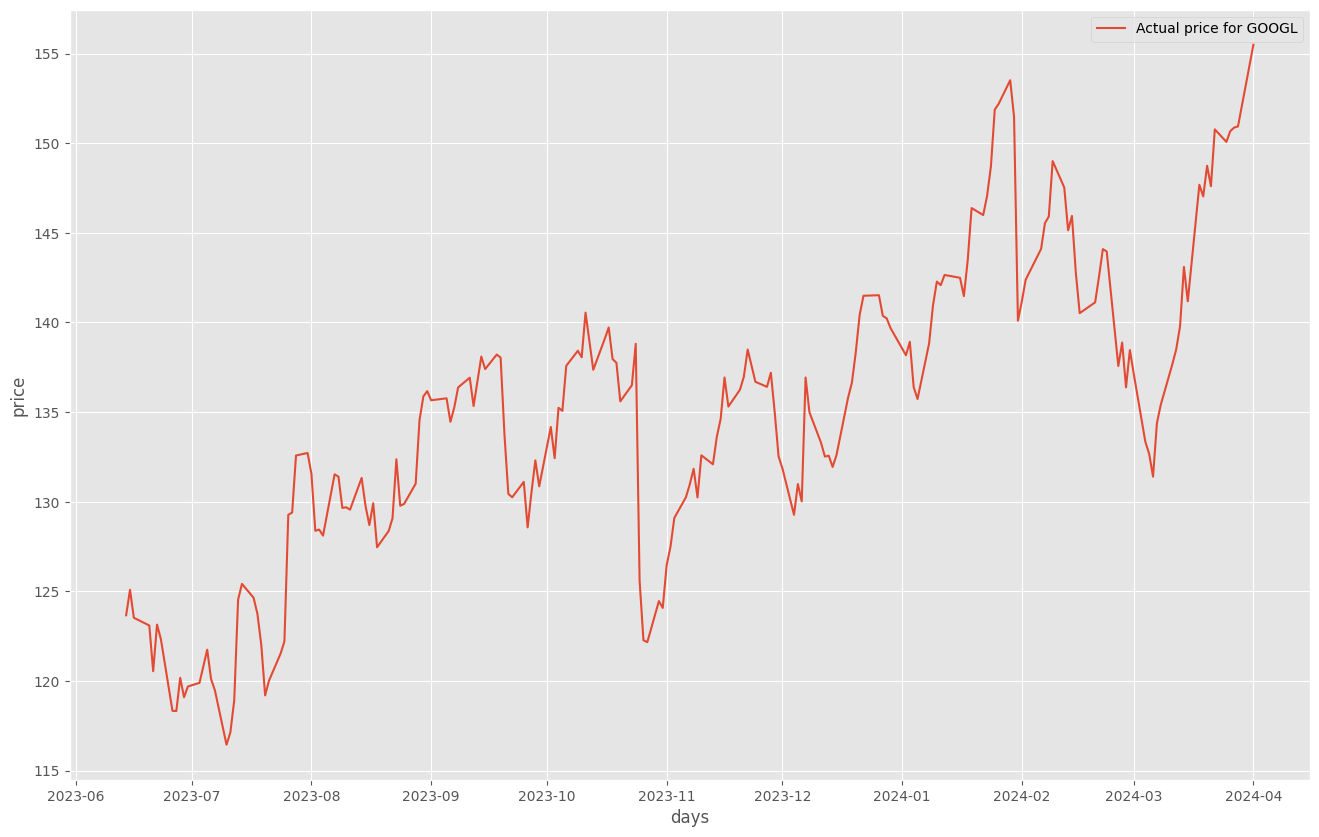

In [8]:
# Let's preliminary see our data on the graphic
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(init_df['close'][-200:])
plt.xlabel('days')
plt.ylabel('price')
plt.legend([f'Actual price for {STOCK}'])
plt.show()

In [9]:
# Scale data for ML engine
scaler = MinMaxScaler()
init_df['scaled_close'] = scaler.fit_transform(np.expand_dims(init_df['close'].values, axis=1))

In [10]:
init_df

,close,date,scaled_close
2021-03-25,101.623001,2021-03-25,0.252470
2021-03-26,101.236504,2021-03-26,0.247107
2021-03-29,102.289497,2021-03-29,0.261719
2021-03-30,102.323502,2021-03-30,0.262191
2021-03-31,103.125999,2021-03-31,0.273328
...,...,...,...
2024-03-25,150.070007,2024-03-25,0.924785
2024-03-26,150.669998,2024-03-26,0.933111
2024-03-27,150.869995,2024-03-27,0.935887
2024-03-28,150.929993,2024-03-28,0.936719


In [11]:
def PrepareData(days):
  df = init_df.copy()
  df['future'] = df['scaled_close'].shift(-days)
  last_sequence = np.array(df[['scaled_close']].tail(days))
  df.dropna(inplace=True)
  sequence_data = []
  sequences = deque(maxlen=N_STEPS)

  for entry, target in zip(df[['scaled_close'] + ['date']].values, df['future'].values):
      sequences.append(entry)
      if len(sequences) == N_STEPS:
          sequence_data.append([np.array(sequences), target])

  last_sequence = list([s[:len(['scaled_close'])] for s in sequences]) + list(last_sequence)
  last_sequence = np.array(last_sequence).astype(np.float32)

  # construct the X's and Y's
  X, Y = [], []
  for seq, target in sequence_data:
      X.append(seq)
      Y.append(target)

  # convert to numpy arrays
  X = np.array(X)
  Y = np.array(Y)

  return df, last_sequence, X, Y

In [12]:
PrepareData(3) # 3 days

(                 close       date  scaled_close    future
 2021-03-25  101.623001 2021-03-25      0.252470  0.262191
 2021-03-26  101.236504 2021-03-26      0.247107  0.273328
 2021-03-29  102.289497 2021-03-29      0.261719  0.319997
 2021-03-30  102.323502 2021-03-30      0.262191  0.381876
 2021-03-31  103.125999 2021-03-31      0.273328  0.375146
 ...                ...        ...           ...       ...
 2024-03-20  148.740005 2024-03-20      0.906328  0.924785
 2024-03-21  147.600006 2024-03-21      0.890508  0.933111
 2024-03-22  150.770004 2024-03-22      0.934499  0.935887
 2024-03-25  150.070007 2024-03-25      0.924785  0.936719
 2024-03-26  150.669998 2024-03-26      0.933111  1.000000
 
 [756 rows x 4 columns],
 array([[0.89161795],
        [0.88259774],
        [0.9063281 ],
        [0.89050794],
        [0.934499  ],
        [0.92478496],
        [0.9331112 ],
        [0.9358866 ],
        [0.93671924],
        [1.        ]], dtype=float32),
 array([[[0.2524701565867999

In [13]:
def GetTrainedModel(x_train, y_train):
  model = Sequential()
  model.add(LSTM(60, return_sequences=True, input_shape=(N_STEPS, len(['scaled_close']))))
  model.add(Dropout(0.3))
  model.add(LSTM(120, return_sequences=False))
  model.add(Dropout(0.3))
  model.add(Dense(20))
  model.add(Dense(1))

  BATCH_SIZE = 8
  EPOCHS = 80

  model.compile(loss='mean_squared_error', optimizer='adam')

  model.fit(x_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            verbose=1)

  model.summary()

  return model

In [14]:
# GET PREDICTIONS
predictions = []

for step in LOOKUP_STEPS:
  df, last_sequence, x_train, y_train = PrepareData(step)
  x_train = x_train[:, :, :len(['scaled_close'])].astype(np.float32)

  model = GetTrainedModel(x_train, y_train)

  last_sequence = last_sequence[-N_STEPS:]
  last_sequence = np.expand_dims(last_sequence, axis=0)
  prediction = model.predict(last_sequence)
  predicted_price = scaler.inverse_transform(prediction)[0][0]

  predictions.append(round(float(predicted_price), 2))

Epoch 1/80


2024-04-02 08:58:49.306848: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type CPU is enabled.


94/94 [==============================] - 5s 14ms/step - loss: 0.0277
Epoch 2/80
94/94 [==============================] - 1s 14ms/step - loss: 0.0065
Epoch 3/80
94/94 [==============================] - 1s 14ms/step - loss: 0.0059
Epoch 4/80
94/94 [==============================] - 1s 14ms/step - loss: 0.0059
Epoch 5/80
94/94 [==============================] - 1s 14ms/step - loss: 0.0056
Epoch 6/80
94/94 [==============================] - 1s 14ms/step - loss: 0.0047
Epoch 7/80
94/94 [==============================] - 1s 14ms/step - loss: 0.0051
Epoch 8/80
94/94 [==============================] - 1s 14ms/step - loss: 0.0041
Epoch 9/80
94/94 [==============================] - 1s 14ms/step - loss: 0.0041
Epoch 10/80
94/94 [==============================] - 1s 14ms/step - loss: 0.0044
Epoch 11/80
94/94 [==============================] - 1s 14ms/step - loss: 0.0035
Epoch 12/80
94/94 [==============================] - 1s 14ms/step - loss: 0.0036
Epoch 13/80
94/94 [=============================

In [15]:
if bool(predictions) == True and len(predictions) > 0:
  predictions_list = [str(d)+'$' for d in predictions]
  predictions_str = ', '.join(predictions_list)
  message = f'{STOCK} prediction for upcoming 3 days ({predictions_str})'
  
  print(message)

GOOGL prediction for upcoming 3 days (155.52$, 152.93$, 150.79$)


In [16]:
# Execute model for the whole history range
copy_df = init_df.copy()
y_predicted = model.predict(x_train)
y_predicted_transformed = np.squeeze(scaler.inverse_transform(y_predicted))
first_seq = scaler.inverse_transform(np.expand_dims(y_train[:6], axis=1))
last_seq = scaler.inverse_transform(np.expand_dims(y_train[-3:], axis=1))
y_predicted_transformed = np.append(first_seq, y_predicted_transformed)
y_predicted_transformed = np.append(y_predicted_transformed, last_seq)
copy_df[f'predicted_close'] = y_predicted_transformed

24/24 [==============================] - 0s 6ms/step


In [17]:
copy_df

,close,date,scaled_close,predicted_close
2021-03-25,101.623001,2021-03-25,0.252470,112.521500
2021-03-26,101.236504,2021-03-26,0.247107,113.533501
2021-03-29,102.289497,2021-03-29,0.261719,112.231003
2021-03-30,102.323502,2021-03-30,0.262191,112.721497
2021-03-31,103.125999,2021-03-31,0.273328,112.095497
...,...,...,...,...
2024-03-25,150.070007,2024-03-25,0.924785,146.940735
2024-03-26,150.669998,2024-03-26,0.933111,147.473511
2024-03-27,150.869995,2024-03-27,0.935887,150.869995
2024-03-28,150.929993,2024-03-28,0.936719,150.929993


In [18]:
# Add predicted results to the table
date_now = dt.date.today()
date_tomorrow = dt.date.today() + dt.timedelta(days=1)
date_after_tomorrow = dt.date.today() + dt.timedelta(days=2)

copy_df.loc[date_now] = [predictions[0], f'{date_now}', 0, 0]
copy_df.loc[date_tomorrow] = [predictions[1], f'{date_tomorrow}', 0, 0]
copy_df.loc[date_after_tomorrow] = [predictions[2], f'{date_after_tomorrow}', 0, 0]

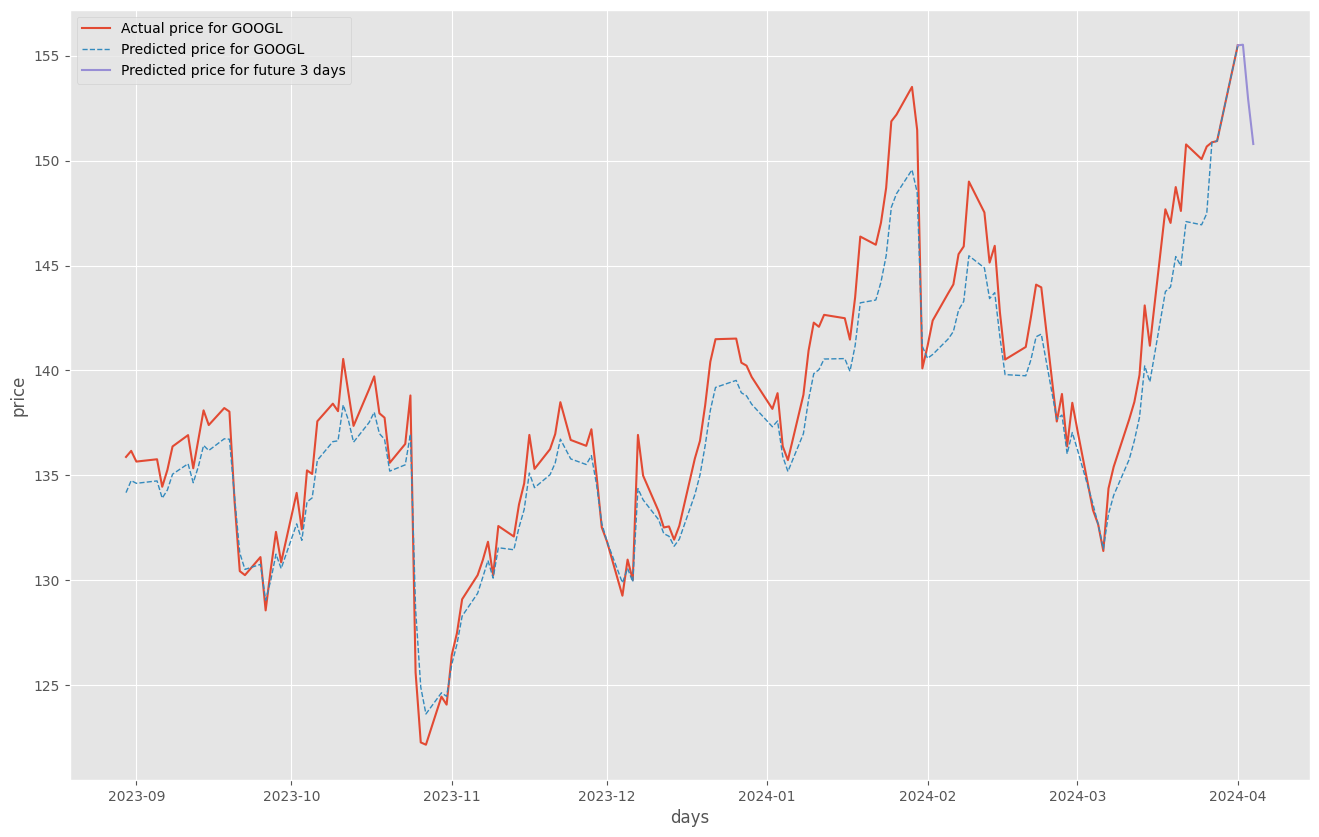

In [19]:
# Result chart
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(copy_df['close'][-150:].head(147))
plt.plot(copy_df['predicted_close'][-150:].head(147), linewidth=1, linestyle='dashed')
plt.plot(copy_df['close'][-150:].tail(4))
plt.xlabel('days')
plt.ylabel('price')
plt.legend([f'Actual price for {STOCK}', 
            f'Predicted price for {STOCK}',
            f'Predicted price for future 3 days'])
plt.show()